# Лабораторная работа 4. Часть 2. Рекомендательные системы.



Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 8 баллов. Сдавать задание после указанного в lk срока сдачи нельзя. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, нам необходима ссылка на источник).



## Знакомство с данными

### Рекомендация организаций, которые получат высокий отзыв от пользователя, когда он гостит в чужом для себя городе

Эта лабораторная работа про задачу из соревнования

https://contest.yandex.ru/contest/36927/problems/


**(1 балла) Задание 1.** Знакомство с данными.

В первую очередь нам понадобятся данные по __пользователям__ (в терминах recsys -- users), __организациям__ (в терминах recsys -- items) и сами __отзывы__ (в терминах recsys -- ratings или explicit feedback). 

На основании этих данных можно будет проводить базовый анализ методами колаборативной фильтрации.

  * Опишите, насколько активно пользователи оставляют отзывы, насколько активно организации получают отзывы.
  * Предложите стратегии фильтрации данных.
  


Во вторую очередь нас будут интересовать атрибуты организаций: aspects, features, rubrics.
Проанализируйте эти таблицы. Какие признаки для описания организаций и пользователей из них можно извлечь?


In [1]:
%load_ext nb_black

import abc
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from functools import partial, reduce

<IPython.core.display.Javascript object>

In [2]:
class DataReader:
    def read(
        self,
        path_to_csv_files="data/*.csv",
        columns_with_space_separated_ints=("rubrics_id", "features_id", "aspects"),
    ):
        data = {}
        for csv_filename in glob.glob(path_to_csv_files):
            basename, extension = os.path.splitext(os.path.basename(csv_filename))
            data[basename] = pd.read_csv(
                csv_filename,
                converters={
                    c: self.read_ints for c in columns_with_space_separated_ints
                },
            )
        return data

    @staticmethod
    def read_ints(line):
        return list(map(int, line.split()))

<IPython.core.display.Javascript object>

In [3]:
data = DataReader().read()

<IPython.core.display.Javascript object>

* Опишите, насколько активно пользователи оставляют отзывы, насколько активно организации получают отзывы.

In [4]:
def describe_review_counts(
    df,
    reviews,
    axis,
    title,
    quantiles=(0, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99, 0.999, 0.9999, 1),
    quantiles_to_plot=(0.5, 0.99, 0.999, 0.9999),
    plt_kwargs=None,
    cmap="hsv",
):
    reviews_count = reviews.groupby(df.index.name).size().reindex(df.index)
    reviews_count.plot(ax=axis, title=title, **(plt_kwargs or {}))
    axis.set_xlabel(plt_kwargs.get("xlabel"))
    axis.set_ylabel(plt_kwargs.get("ylabel"))

    for i, q in enumerate(quantiles_to_plot, start=1):
        quantile = reviews_count.quantile(q=q)
        axis.axvline(quantile, ls="--", c=plt.get_cmap(name=cmap)(q))
        axis.text(quantile, axis.get_ylim()[1] / 2**i, f"{100*q}%", ha="left")

    return reviews_count.agg(
        {
            "mean": pd.Series.mean,
            "std": pd.Series.std,
            **{f"{100*q}%": partial(pd.Series.quantile, q=q) for q in quantiles},
        }
    )


def show_review_counts(data):
    users = data["users"].set_index("user_id")
    organisations = data["organisations"].set_index("org_id")
    reviews = data["reviews"]
    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
    plt_kwargs = dict(
        kind="hist",
        log=True,
        histtype="stepfilled",
        bins=100,
        edgecolor="black",
        facecolor="gray",
        alpha=0.5,
        xlabel="Reviews count",
        ylabel="Frequency (log scale)",
    )
    return pd.DataFrame(
        {
            title: describe_review_counts(
                df,
                reviews,
                axis,
                title=title,
                plt_kwargs=plt_kwargs,
            )
            for df, axis, title in zip(
                [users, organisations],
                axes,
                ["Users reviews written", "Organisations reviews received"],
            )
        }
    ).T

<IPython.core.display.Javascript object>

,mean,std,0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,99.9%,99.99%,100%
Users reviews written,2.964589,4.854616,1.0,1.0,1.0,3.0,6.0,10.0,22.0,54.000,117.0000,611.0
Organisations reviews received,60.429564,436.475347,1.0,2.0,8.0,32.0,125.0,246.0,785.0,3021.324,15019.8882,61520.0


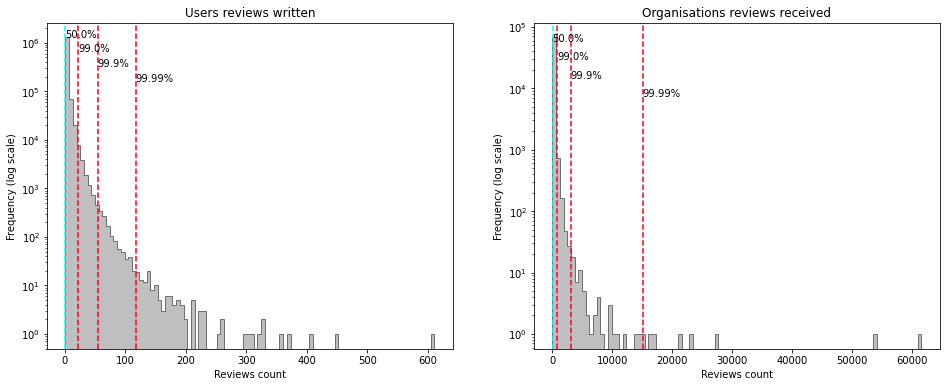

<IPython.core.display.Javascript object>

In [5]:
show_review_counts(data)

* Предложите стратегии фильтрации данных.

Отбросить организации, у которых мало оценок и все они негативные. Это наименее полезные для нас организации, поскольку они одновременно не дают много информации о взаимных интересах пользователей, и не пригодятся для конечных рекомендаций.

Реализация этой стратегии может выглядеть так: мы сортируем организации по значению функции полезности

$$f(\text{organisation}) = (\text{rating count})(1 + \text{rating std})^\alpha (\text{mean rating})^\beta$$

И отсекаем $\gamma$ первых организаций, где $\alpha, \beta$ и $\gamma$ подбираются по нашим предпочтениям.

In [6]:
class Preprocessor:
    @staticmethod
    def filter(reviews, alpha=1, beta=1, gamma=0.9):
        reviews = reviews.dropna(subset=["rating"])
        usefulness = reviews.groupby("org_id").apply(
            partial(ReviewsFilter.calculate_usefulness, alpha=alpha, beta=beta),
        )
        org_ids_to_keep = usefulness.sort_values().index[
            -int(gamma * len(usefulness)) :
        ]
        return reviews.query("org_id in @org_ids_to_keep")

    @staticmethod
    def calculate_usefulness(org_df, alpha, beta):
        usefulness = (
            len(org_df)
            * (1 + org_df["rating"].std(ddof=0)) ** alpha
            * org_df["rating"].mean() ** beta
        )
        return usefulness

    @staticmethod
    def single_train_test_split(reviews, fraction_of_max_possible_test_size):
        ts_grouped_by_user_id = reviews.groupby("user_id")["ts"]
        ranks = ts_grouped_by_user_id.rank(method="first").rename("rank")
        sizes = ts_grouped_by_user_id.size().rename("size")
        test_prob = (
            reviews[["user_id"]]
            .join(ranks)
            .join(sizes, on="user_id")
            .pipe(lambda df: (df["rank"] - 1) / (df["size"] - 1).replace({0: 1}))
            .pipe(lambda s: s / s.sum())
        )
        max_possible_test_size = test_prob.astype(bool).sum()
        test_index = np.random.permutation(
            np.random.choice(
                reviews.index,
                size=int(fraction_of_max_possible_test_size * max_possible_test_size),
                replace=False,
                p=test_prob,
            )
        )
        test = reviews.loc[test_index]
        train = reviews.drop(test_index).query("user_id in @test.user_id")
        return train, test

    @staticmethod
    def train_test_split(reviews, test_fractions):
        total_test_fraction = sum(test_fractions)
        train, test = Preprocessor.single_train_test_split(reviews, total_test_fraction)
        test_sizes = [int(len(test) * i / total_test_fraction) for i in test_fractions]
        test_splits = []
        for begin, end in zip(np.cumsum([0] + test_sizes), np.cumsum(test_sizes)):
            test_splits.append(test.iloc[begin:end])

        return train, test_splits

    def build_ids_map(self, users, organisations):
        self.user_id_map = users["user_id"].sort_index()
        self.reverse_user_id_map = pd.Series(
            self.user_id_map.index, self.user_id_map.values
        ).sort_index()
        self.org_id_map = organisations["org_id"].sort_index()
        self.reverse_org_id_map = pd.Series(
            self.org_id_map.index, self.org_id_map.values
        ).sort_index()

    def map_ids(self, data):
        self.build_ids_map(data["users"], data["organisations"])
        for key, df in data.items():
            if "user_id" in df:
                df["user_id"] = self.reverse_user_id_map.loc[df["user_id"]].values
            if "org_id" in df:
                df["org_id"] = self.reverse_org_id_map.loc[df["org_id"]].values
            data[key] = df
        return data

<IPython.core.display.Javascript object>

In [7]:
preprocessor = Preprocessor()
# d = preprocessor.map_ids(data)

<IPython.core.display.Javascript object>

In [9]:
preprocessor.build_ids_map(data["users"], data["organisations"])

<IPython.core.display.Javascript object>

In [ ]:
data["users"].head(100).replace({"user_id": preprocessor.reverse_user_id_map})

In [ ]:
d["users"]

In [ ]:
pd.DataFrame.replace(data, self.user_id_map, value=)

* Во вторую очередь нас будут интересовать атрибуты организаций: aspects, features, rubrics. Проанализируйте эти таблицы. Какие признаки для описания организаций и пользователей из них можно извлечь?

Эти таблицы содержат текстовые описания, так что можно взять их эмбединги или обучить латентные векторные представления, либо кластеризовать и взять метки кластеров, и использовать все это в качестве дополнительных признаков.

---

**(1 балла) Задание 2.** Организация валидации.

Как вы помните, обучающее множество собрано за X = 1277 дней, тестовое множество – за последующие Y = 107 дней.

Следовательно нам необходимо организовать у себя валидацию схожим образом.
Раз мы будем еще и осуществлять выбор моделей, то следует произвести расщепление по времени на 3 группы train validation и holdout.

Как уже говорилось на семинаре, для повышения качества локальной валидации, можно сделать скользящую валидацию. В самой лабораторной работе мы так делать не будем, но для конкурса имейте это в виду.


In [14]:
train_reviews, (validation_reviews, holdout_reviews) = Preprocessor().train_test_split(
    reviews, test_fractions=[0.3, 0.3]
)

<IPython.core.display.Javascript object>

**(0.5 балла) Задание 3.** Базовые решения.

Сделаем базовые решения:
  * Для каждого пользователя выдаём 20 случайных организаций
  * Для каждого пользователя выдаём самые популярные организации в неродном городе

In [135]:
class RandomRecommender:
    def fit(self, reviews):
        self.org_ids = reviews["org_id"].unique()
        return self

    def recommend(self, user_ids, recommend_size=20):
        recommendations = np.random.choice(
            self.org_ids, size=(len(user_ids), recommend_size)
        )
        return pd.DataFrame(recommendations, user_ids)


class PopularRecommender:
    def __init__(self, users, organisations):
        self.users = users
        self.organisations = organisations

    def fit(self, reviews):
        self.popular_foreign_organisations_for_home_city = {}
        organisations = self.organisations.join(
            reviews.groupby("org_id").size().rename("popularity")
        )

        for city in organisations["city"].unique():
            self.popular_foreign_organisations_for_home_city[city] = (
                organisations.query("city != @city")
                .sort_values("popularity", ascending=False)
                .index.to_numpy()
            )
        return self

    def recommend(self, user_ids, recommend_size=20):
        s = pd.Series(
            {
                city: orgs[:recommend_size]
                for city, orgs in self.popular_foreign_organisations_for_home_city.items()
            }
        )

        recommendations = pd.DataFrame(
            np.stack(s.loc[self.users.loc[user_ids]["city"]].values), user_ids
        )

        return recommendations

<IPython.core.display.Javascript object>

**(1.0 балла) Задание 4.** Метрики качества.

Напомним, что у нас бинарная релевантнотсь на основе оценки вычисляется как предикат **оценка больше, чем 3**.

Реализуйте набор метрик качества (можете оборачивать внешние паекты):

    * MNAP@20 (как в описании соревнования)
    * HitRate ( = 1, если среди рекомендаций есть хотя бы одна релевантная и 0 иначе)
    * MRR@20 ( обратная позиция первой релевантной рекомендации из списка рекомендаций длины K. )
    * Coverage (доля item-ов, учитываемых в рекомендациях)
    * Surprisal(см. ниже) 


### Surprisal
Посмотирм, насколько наши рекомендации хороши с точки зрения новизны для пользователя, в качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

Будем рассматривать собственную информацию item-а как меру его новизны.

$$selfInformation(i) = -\log_2 \frac{|u_i|}{|N|}$$, 
где 
$i$ - объект, $|N|$ - число взаимодействий в обучающей выборке,  $|u_i|$ - число пользователей, взаимодействовавших с объектом в обучающей выборке.

После подсчета собственной информации усредним значения собственной информации в рекомендациях пользователя.

Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u)@k = \frac{1}{k \cdot log_2 N} \sum_{j = 1}^{k}selfInformation(i_{u,j})$$

где $i_{u,j}$ это j-й объект, который мы порекомендововали пользователю.

Получившаяся метрика похожа на энтропию Шеннона:
$$H = - K \sum_{i\in R}{p_i log p_i}$$


Результа усредним по пользователям.

### Что нужно сделать
    
  * Создайте функцию, которая генерирует словарь с метриками, по предоставленному решению.

  * Оцените baseline-решения на валидации.

In [132]:
class MetricsBase:
    def __init__(self, users, organisations, reviews, k=20):
        self.users = users
        self.organisations = organisations
        self.reviews = reviews
        self.k = k
        self.relevant_orgs_for_users = (
            reviews.query("rating >= 4")
            .groupby("user_id")["org_id"]
            .apply(np.array)
            .rename("relevant_org_ids")
        )
        self.recommendations = None
        self.relevance = None

    def binary_relevance(self, recommendations):
        relevance = (
            pd.merge(
                recommendations.agg(np.array, axis="columns").rename(
                    "predicted_org_ids"
                ),
                self.relevant_orgs_for_users,
                left_index=True,
                right_index=True,
                how="left",
            )
            .aggregate(
                lambda row: np.isin(row["predicted_org_ids"], row["relevant_org_ids"]),
                axis="columns",
            )
            .pipe(
                lambda series: pd.DataFrame(np.stack(series.values), index=series.index)
            )
        )
        return relevance

    def precalculate(self, recommendations):
        self.recommendations = recommendations
        self.relevance = self.binary_relevance(recommendations.iloc[:, : self.k])

    @staticmethod
    def wrap_metric(metric):
        """Precalculate relevance if recommendations were passed."""

        def wrapper(self, recommendations=None, **kwargs):
            if recommendations is not None:
                self.precalculate(recommendations)
            elif self.recommendations is None:
                raise ValueError(
                    "recommendations must be passed when first calculating a metric."
                )
            return metric(self, **kwargs)

        return wrapper

    def __init_subclass__(cls):
        """Wrap all subclass attributes"""
        super().__init_subclass__()
        for child_attribute in cls.__dict__.keys() - MetricsBase.__dict__.keys():
            setattr(
                cls,
                child_attribute,
                MetricsBase.wrap_metric(object.__getattribute__(cls, child_attribute)),
            )


class Metrics(MetricsBase):
    def precision(self):
        precision = self.relevance.astype(int).cumsum(axis="columns") / np.arange(
            1, self.relevance.shape[1] + 1
        )
        return precision

    def ideal_precision(self):
        relevant_count = (
            self.reviews.query("user_id in @self.recommendations.index and rating >= 4")
            .groupby("user_id")
            .size()
            .reindex(self.relevance.index)
        )

        def relevant_count_to_ideal_average_precision(count):
            k = np.arange(1, self.k + 1)
            ideal_relevant_count = np.minimum(k, count)
            return np.mean(ideal_relevant_count / k)

        return relevant_count.map(relevant_count_to_ideal_average_precision)

    def mnap(self):
        """Returns mean normalized average precision"""
        average_precision = self.precision().mean("columns")
        ideal_precision = self.ideal_precision()
        return np.nanmean(average_precision / ideal_precision)

    def hitrate(self):
        return self.relevance.any(axis="columns").mean()

    def mrr(self):
        """Returns mean reciprocal rank"""
        relevance = self.relevance.values
        return (
            (relevance * (1 / np.arange(1, relevance.shape[1] + 1))).max(axis=1).mean()
        )

    def coverage(self):
        org_ids = set(self.organisations.index)
        recommended_org_ids = set(self.recommendations.values.flat)
        return len(recommended_org_ids & org_ids) / len(org_ids)

    def surprisal(self):
        org_interactions = (
            self.reviews.groupby("org_id")
            .size()
            .reindex(self.organisations.index)
            .replace(0, np.nan)
        )
        recommended_interactions = self.recommendations.applymap(
            lambda org_id: org_interactions[org_id] if org_id else np.nan
        )
        self_information = -np.log2(recommended_interactions) + np.log2(
            len(self.reviews)
        )
        return (self_information / np.log2(len(self.reviews))).mean().mean()

    def calculate_metrics(self, name=None):
        results = pd.Series(dtype=float, name=name)
        for metric in ["mnap", "hitrate", "mrr", "coverage", "surprisal"]:
            results[metric] = getattr(self, metric)()
        return results

<IPython.core.display.Javascript object>

In [133]:
class Assessor:
    def __init__(self, users, organisations, train_reviews, validation_reviews):
        self.users = users
        self.organisations = organisations
        self.train_reviews = train_reviews
        self.train_users = train_reviews["user_id"].unique()
        self.validation_users = validation_reviews["user_id"].unique()
        self.metrics = Metrics(users, organisations, validation_reviews)
        self.assessments = {}

    def assess_model(self, model, name):
        model.fit(self.train_reviews)
        train_recommendations = model.recommend(self.train_users)
        val_recommendations = model.recommend(self.validation_users)
        results = self.metrics.calculate_metrics(val_recommendations, name=name)
        self.assessments[name] = {
            "train_recommendations": train_recommendations,
            "val_recommendations": val_recommendations,
            "results": results,
        }

    def assess(self, models):
        for name, model in models.items():
            self.assess_model(model, name)
        self.show_results()

    def show_results(self):
        results = pd.concat(
            [i["results"] for i in self.assessments.values()], axis="columns"
        )
        results.plot(
            kind="barh",
            log=True,
            title="Model metrics, log scale",
            figsize=(10, 6),
        )

<IPython.core.display.Javascript object>

In [137]:
assessor = Assessor(users, organisations, train_reviews, validation_reviews)

<IPython.core.display.Javascript object>

In [136]:
baseline_models = {
    "random": RandomRecommender(),
    "popular": PopularRecommender(users, organisations),
}
assessor.assess(baseline_models)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

**(1.0 балла) Задание 5.** Метод Memory based. User-2-User or Item-2-Item

Теперь рассмотрим [memory-based](https://en.wikipedia.org/wiki/Collaborative_filtering#Memory-based) методы рекоммендаций.
Подход, лежащий в их основе, использует данные о рейтингах для вычисления сходства между пользователями (user-based) или объектами (item-based), на основе этих данных делаются предсказания рейтингов и, в дальнейшем, строятся рекоммендации. Эти методы просты в реализации и эффективны на ранних стадиях разработки рекомендательных систем.
                                 
              
За последние годы было создано много библиотек для реализации алгоримтов построения рекомендаций.      
  * https://github.com/benfred/implicit
  * https://sberbank-ai-lab.github.io/RePlay/index.html
  * https://github.com/apple/turicreate 
  * https://github.com/caserec/CaseRecommender

Выеберите одну из них и постройте предсказания на основании совместной фильтрации по близости пользователей или по близости объектов.

Если обучение идёт слишком долго подумайте про семплирование данных. Обоснуйте выбранную стратегию семплирования.



In [114]:
import implicit

from lightfm.data import Dataset
from scipy.sparse import coo_matrix, csr_matrix
from tqdm.auto import tqdm


class SparseInterface:
    def __init__(self, data):
        self.users = data["users"]
        self.organisations = data["organisations"]
        self.data = data
        self.dataset = Dataset()

    def build(self):
        self.fit()
        self.build_user_features()
        self.build_item_features()
        (
            self.user_id_map,
            self.user_feature_map,
            self.item_id_map,
            self.item_feature_map,
        ) = self.dataset.mapping()
        self.user_id_map = pd.Series(self.user_id_map)
        item_id_map = pd.Series(self.item_id_map)
        self.item_id_map_reverse = pd.Series(item_id_map.index, item_id_map.values)
        self.item_id_map_reverse[0] = 0

    def fit(self):
        self.dataset.fit(
            users=self.users.index,
            items=self.organisations.index,
            user_features=self.users["city"].unique(),
            item_features=list(self.organisations["city"].unique())
            + ["average_bill", "rating"]
            + [f"rubric_{rubric_id}" for rubric_id in self.data["rubrics"].index]
            + [f"feature_{feature_id}" for feature_id in self.data["features"].index],
        )

    def build_user_features(self):
        self.user_features = self.dataset.build_user_features(
            zip(self.users.index, self.users[["city"]].values), normalize=False
        )

    def build_item_features(self):
        self.item_features = self.dataset.build_item_features(
            (
                (
                    org_id,
                    {
                        **{org_row["city"]: True},
                        **org_row[["average_bill", "rating"]].dropna().to_dict(),
                        **{
                            f"rubric_{rubric_id}": True
                            for rubric_id in org_row["rubrics_id"]
                        },
                        **{
                            f"feature_{feature_id}": True
                            for feature_id in org_row["features_id"]
                        },
                    },
                )
                for org_id, org_row in tqdm(
                    self.organisations.iterrows(),
                    "Building item features",
                    total=len(self.organisations),
                )
            ),
            normalize=False,
        )

    def build_interactions(self, reviews):
        self.interactions, self.interactions_weighted = self.dataset.build_interactions(
            reviews[["user_id", "org_id", "rating"]].dropna().astype("uint64").values
        )

    def user_ids_to_latent(self, user_ids):
        return self.user_id_map.loc[user_ids]

    def recommended_org_ids_from_latent(self, latent_recommendations):
        recommendations = latent_recommendations.apply(
            lambda s: self.item_id_map_reverse.loc[s].values
        )
        return recommendations

<IPython.core.display.Javascript object>

In [115]:
class ImplicitRecommender(BaseRecommender):
    def __init__(self, sparse_interface, model):
        self.model = model
        self.sparse_interface = sparse_interface

    def fit(self, reviews):
        self.sparse_interface.build_interactions(reviews)
        self.interactions = csr_matrix(self.sparse_interface.interactions_weighted)
        self.model.fit(self.interactions)
        return self

    def recommend(self, user_ids, recommend_size=20):
        user_ids_mapped = self.sparse_interface.user_ids_to_latent(user_ids)
        recommendations, predicted_ratings = self.model.recommend(
            userid=user_ids_mapped,
            user_items=self.interactions[user_ids_mapped],
            N=recommend_size,
        )
        recommendations = pd.DataFrame(recommendations, user_ids).replace(-1, 0)
        return self.sparse_interface.recommended_org_ids_from_latent(recommendations)

<IPython.core.display.Javascript object>

In [19]:
sparse_interface = SparseInterface(data)
sparse_interface.build()

Building item features:   0%|          | 0/68339 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

/external2/dkkoshman/venv/lib/python3.6/site-packages/implicit/nearest_neighbours.py:226: RuntimeWarning: invalid value encountered in true_divide
  X.data = X.data / sqrt(bincount(X.row, X.data**2))[X.row]
/external2/dkkoshman/venv/lib/python3.6/site-packages/implicit/utils.py:141: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.002620697021484375 seconds
  ParameterWarning,


  0%|          | 0/68339 [00:00<?, ?it/s]

/external2/dkkoshman/venv/lib/python3.6/site-packages/implicit/utils.py:141: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0027480125427246094 seconds
  ParameterWarning,


  0%|          | 0/68339 [00:00<?, ?it/s]

/external2/dkkoshman/venv/lib/python3.6/site-packages/implicit/nearest_neighbours.py:226: RuntimeWarning: invalid value encountered in true_divide
  X.data = X.data / sqrt(bincount(X.row, X.data**2))[X.row]
/external2/dkkoshman/venv/lib/python3.6/site-packages/implicit/utils.py:141: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004286527633666992 seconds
  ParameterWarning,


  0%|          | 0/68339 [00:00<?, ?it/s]

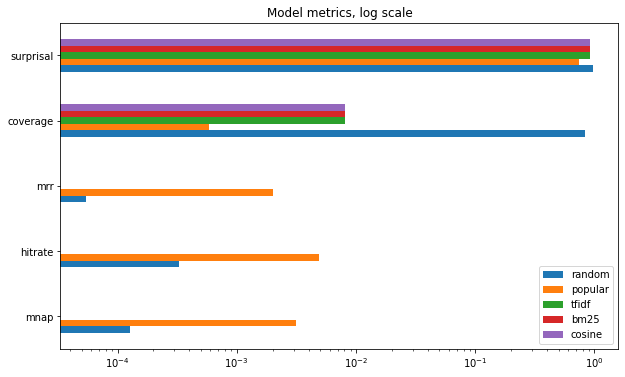

<IPython.core.display.Javascript object>

In [116]:
nn_models = {
    "tfidf": ImplicitRecommender(
        sparse_interface, implicit.nearest_neighbours.TFIDFRecommender()
    ),
    "bm25": ImplicitRecommender(
        sparse_interface, implicit.nearest_neighbours.BM25Recommender()
    ),
    "cosine": ImplicitRecommender(
        sparse_interface, implicit.nearest_neighbours.CosineRecommender()
    ),
}

assessor.assess(nn_models)

## Методы Matrix factorization

**(0.5 балла) Задание 6.**

- Разложите матрицу рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) и, восстановив ее, получите предсказания рейтингов для всех пар пользователь-объект. В данном случае неизвестные рейтинги заполняются нулями, а затем восстанавливаются с помощью SVD (этот метод называется PureSVD).
   * Получив векторные представления пользователей и объектов и сингулярные числа, мы можеи восстановив матрицу и в местах нулей получим "предсказанные значения вероятностей" для новых объектов.
- Рассмотрите, как минимум, 5 различных значений ранга разложения. Оцените качество рекомендаций

Получим представление о том, какие варианты значенией ранга разложения следует попробовать:

In [27]:
from sklearn.decomposition import TruncatedSVD


def plot_component_importance(sparse_interface, n_components=100):
    truncated_svd = TruncatedSVD(n_components=n_components)
    truncated_svd.fit(sparse_interface.interactions_weighted)

    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(truncated_svd.explained_variance_ratio_)
    plt.xlabel("n components")
    plt.ylabel("explained variance ratio")
    plt.title("Explained variance depending on number of components")

<IPython.core.display.Javascript object>

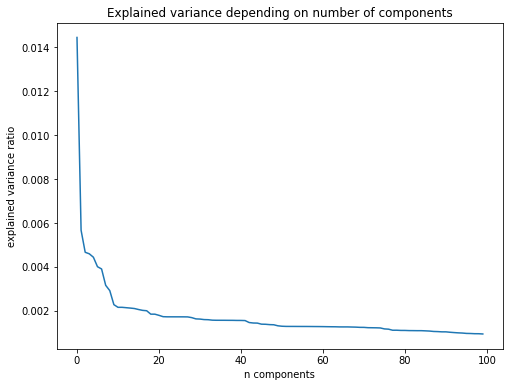

<IPython.core.display.Javascript object>

In [69]:
plot_component_importance(sparse_interface)

In [28]:
class BatchRecommender(ImplicitRecommender):
    def recommend(self, user_ids, recommend_size=20, batch_size=1024):
        user_ids_mapped = self.sparse_interface.user_ids_to_latent(user_ids)
        interactions = self.interactions[user_ids_mapped]
        recommendations = []

        for begin in tqdm(range(0, len(user_ids), batch_size), "Predicting"):
            batch_slice = slice(begin, begin + batch_size)
            batch_interactions = interactions[batch_slice]
            batch_ids = user_ids[batch_slice]
            batch_ids_mapped = user_ids_mapped[batch_slice]
            batch_rec = self.model_recommend(batch_ids_mapped, batch_interactions)
            batch_rec = np.argpartition(-batch_rec, recommend_size)[:, :recommend_size]
            batch_rec = pd.DataFrame(batch_rec, batch_ids)
            recommendations.append(batch_rec)

        recommendations = self.sparse_interface.recommended_org_ids_from_latent(
            pd.concat(recommendations)
        )
        return recommendations

    @abc.abstractmethod
    def model_recommend(self, user_ids, interactions):
        ...


class SVDRecommender(BatchRecommender):
    def model_recommend(self, user_ids, interactions):
        embedding = self.model.transform(interactions)
        recommendations = self.model.inverse_transform(embedding)
        return recommendations

<IPython.core.display.Javascript object>

Predicting:   0%|          | 0/7 [00:00<?, ?it/s]

Predicting:   0%|          | 0/7 [00:00<?, ?it/s]

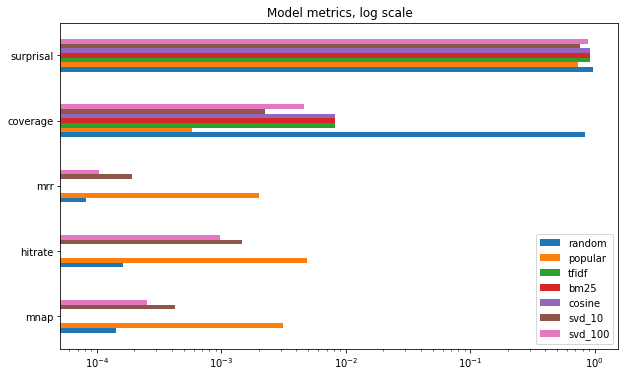

<IPython.core.display.Javascript object>

In [29]:
matrix_factorization_models = {
    f"svd_{n_components}": SVDRecommender(
        sparse_interface, TruncatedSVD(n_components=n_components)
    )
    for n_components in np.logspace(1, 2, num=2, dtype=int)
}

assessor.assess(matrix_factorization_models)

# ALS
Довольно популярным базовым методом в рекомендательных системах является ALS.

### Explicit ALS

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$

### [Implicit ALS](http://yifanhu.net/PUB/cf.pdf)

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} c_{ui}(p_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$
Где $c_{ui}$ - значение в матрице implicit feedback, а $p_{ui}$ равно 1, если пользователь u взаимодействовал с item-ом i, и 0 иначе.

### Усложнения ALS
Обучив для каждого пользователя и объекта свой bias и добавив регуляризацию можно улучшить качество решения. Подробнее о различных матричных разложениях для задачи рекомендаций можно почитать [в статье на Хабре](https://habr.com/ru/post/486802/).

В рейтинг объекта для пользователя, например, может быть представлен:
$$r_{ui} = \mu + b_i + b_u + q_i^T p_u$$

А функция потерь будет выглядеть так:
$$\min_{b*, p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - \mu - b_i - b_u - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2 + b_i^2 + b_u^2)$$

Матричная факторизация - хороший подход, который позволяет получить рекомендации для теплых пользователей, а также находить похожих пользователей и объекты, посчитав расстояния между векторами. Обучив модель и получив вектора можно перейти от задачи рекомендаций к задаче поиска ближайших соседей и использовать ANN-методы.

**(1.0 балла) Задание 7.**
Примените ALS.

Можно воспользоваться готовой реализацией из бибилотеки https://github.com/benfred/implicit

Попробуйте использовать как все оценки, так и только высокие. Есть ли разница?

In [30]:
from implicit.gpu.als import AlternatingLeastSquares


class ALSFiltered(ImplicitRecommender):
    def __init__(self, *args, filtered_train_reviews, **kwargs):
        super().__init__(*args, **kwargs)
        self.filtered_train_reviews = filtered_train_reviews

    def fit(self, reviews):
        super().fit(self.filtered_train_reviews)

<IPython.core.display.Javascript object>

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

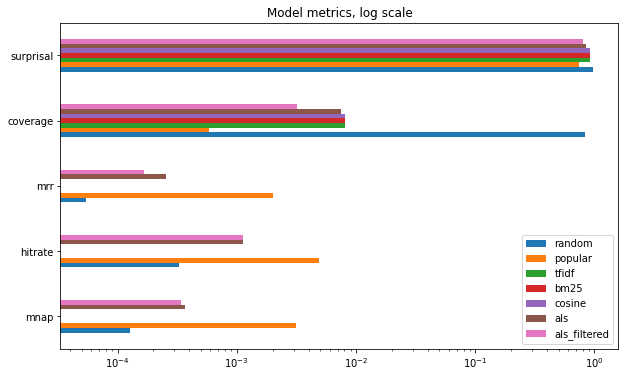

<IPython.core.display.Javascript object>

In [117]:
als_models = {
    "als": ImplicitRecommender(sparse_interface, AlternatingLeastSquares()),
    "als_filtered": ALSFiltered(
        sparse_interface,
        AlternatingLeastSquares(),
        filtered_train_reviews=train_reviews.query("rating >= 4").assign(rating=1),
    ),
}
assessor.assess(als_models)

**(1.0 балла) Задание 8.**

На [семинаре](https://github.com/monkey0head/recsys_sem) Вам было расказано про бибилиотеку LightFM.
Примените ее для нашей задачи. Используя фичи и не используя фичи, сравните результат.

In [32]:
# TODO: add aspects, gridsearch
from lightfm import LightFM


class LightRecommender(BatchRecommender):
    def __init__(self, *args, with_features=True, **kwargs):
        super().__init__(*args, **kwargs)
        self.with_features = with_features
        self.user_features = (
            self.sparse_interface.user_features if with_features else None
        )
        self.item_features = (
            self.sparse_interface.item_features if with_features else None
        )

    def fit(self, reviews):
        self.sparse_interface.build_interactions(reviews)
        self.interactions = csr_matrix(self.sparse_interface.interactions_weighted)
        self.model.fit(
            interactions=self.sparse_interface.interactions,
            sample_weight=self.sparse_interface.interactions_weighted,
            user_features=self.user_features,
            item_features=self.item_features,
            epochs=100,
            num_threads=8,
            verbose=True,
        )
        return self

    def model_recommend(self, user_ids, interactions):
        user_ids, item_ids = np.meshgrid(
            user_ids, range(len(self.sparse_interface.organisations)), indexing="ij"
        )

        recommendations = self.model.predict(
            user_ids=user_ids.flatten(),
            item_ids=item_ids.flatten(),
            user_features=self.user_features,
            item_features=self.item_features,
            num_threads=8,
        ).reshape(user_ids.shape)

        return recommendations

<IPython.core.display.Javascript object>

Epoch: 100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


Predicting:   0%|          | 0/28 [00:00<?, ?it/s]

Predicting:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 100%|██████████| 100/100 [00:03<00:00, 31.54it/s]


Predicting:   0%|          | 0/28 [00:00<?, ?it/s]

Predicting:   0%|          | 0/7 [00:00<?, ?it/s]

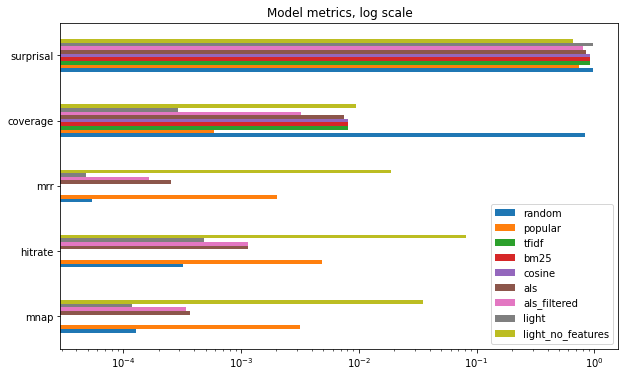

<IPython.core.display.Javascript object>

In [118]:
light_models = {
    "light": LightRecommender(sparse_interface, LightFM()),
    "light_no_features": LightRecommender(
        sparse_interface, LightFM(), with_features=False
    ),
}
assessor.assess(light_models)

**(1.0 балла) Задание 9.**

   Посмотрим на все прошлые методы как на модели, которые генерируют нам кандидатов для ответа рекомендательной системы. 
   
   Как нам выбрать те 20 организаций наилучшим образом? 
   
   Давайте подключим машинное обучение. Сформулируем задачу ранжирования: запросом будет пользователь. Документами будут организации. Наивным признаковым описанием будет, например, факт рекомендации данной организации или скор/ранг от моделей SVD, ALS, LightFM.
   Примените catboost/xgboost/lightgbm для создания переранжирования рекомендаций. То есть сделаем двухуровневую модель. Выясните наиболее важные признаки моделей первого уровня.

In [126]:
train_model_ranks = []
for model_name, assessment in assessor.assessments.items():
    train_recommendations = assessment["train_recommendations"]
    train_model_ranks.append(
        pd.concat(
            [
                column.pipe(lambda column: column[column != 0]).pipe(
                    lambda column: pd.Series(
                        rank, pd.MultiIndex.from_arrays([column.index, column.values])
                    )
                )
                for rank, (column_name, column) in enumerate(
                    train_recommendations.iteritems()
                )
            ]
        )
        .rename(model_name)
        .pipe(lambda df: df.loc[~df.index.duplicated(keep="first")])
    )
train_model_ranks = pd.concat(train_model_ranks, axis="columns")

<IPython.core.display.Javascript object>

In [135]:
def get(assessor, what):
    model_ranks = []
    for model_name, assessment in assessor.assessments.items():
        recommendations = assessment[what]
        model_ranks.append(
            pd.concat(
                [
                    column.pipe(lambda column: column[column != 0]).pipe(
                        lambda column: pd.Series(
                            rank,
                            pd.MultiIndex.from_arrays([column.index, column.values]),
                        )
                    )
                    for rank, (column_name, column) in enumerate(
                        recommendations.iteritems()
                    )
                ]
            )
            .rename(model_name)
            .pipe(lambda df: df.loc[~df.index.duplicated(keep="first")])
        )
    model_ranks = pd.concat(model_ranks, axis="columns")
    return model_ranks

<IPython.core.display.Javascript object>

In [136]:
val_model_ranks = get(assessor, "val_recommendations")

<IPython.core.display.Javascript object>

In [127]:
train_model_ranks

random  popular  tfidf  bm25  \
1175872067657083     122414194213400986       6.0      NaN    NaN   NaN   
                     306420097920315807       NaN      NaN    NaN   NaN   
                     336748997849365911       NaN     15.0    NaN   NaN   
                     692169555821985307      17.0      NaN    NaN   NaN   
                     704439103212148053       9.0      NaN    NaN   NaN   
...                                           ...      ...    ...   ...   
18446667718072798938 17935925087821884307    13.0      NaN    NaN   NaN   
                     17982178577376386736     NaN      NaN    NaN   NaN   
                     17999708768616662496     NaN      NaN    NaN   NaN   
                     18337374435746134790     NaN      NaN    NaN   NaN   
                     18408655768418834208     NaN      NaN    NaN   NaN   

                                           cosine   als  als_filtered  light  \
1175872067657083     122414194213400986       NaN   NaN           NaN    NaN   
                     306420097920315807       NaN  12.0           NaN    NaN   
                     336748997849365911       NaN   NaN           NaN    NaN   
                     692169555821985307       NaN   NaN           NaN    NaN   
                     704439103212148053       NaN   NaN           NaN    NaN   
...                                           ...   ...           ...    ...   
18446667718072798938 17935925087821884307     NaN   NaN           NaN    NaN   
                     17982178577376386736     NaN   NaN           NaN    4.0   
                     17999708768616662496     NaN   NaN           NaN    2.0   
                     18337374435746134790     NaN   NaN           NaN    NaN   
                     18408655768418834208     NaN   NaN           NaN    9.0   

                                           light_no_features  
1175872067657083     122414194213400986                  NaN  
                     306420097920315807                  NaN  
                     336748997849365911                  NaN  
                     692169555821985307                  NaN  
                     704439103212148053                  NaN  
...                                                      ...  
18446667718072798938 17935925087821884307                NaN  
                     17982178577376386736                NaN  
                     17999708768616662496                NaN  
                     18337374435746134790               13.0  
                     18408655768418834208                NaN  

[2991081 rows x 9 columns]

<IPython.core.display.Javascript object>

In [36]:
import catboost

<IPython.core.display.Javascript object>

In [131]:
# what to do with unknown y?
# scale item, user features
def cb_transform(model_ranks, sparse_interface, reviews):
    X = model_ranks.reset_index(drop=True).fillna(-1).astype(int)
    y = (
        reviews.set_index(["user_id", "org_id"])["rating"]
        .reindex(model_ranks.index)
        .fillna(0)
    )
    group_id = sparse_interface.user_ids_to_latent(
        model_ranks.index.get_level_values(0)
    ).values
    return X, y, group_id

<IPython.core.display.Javascript object>

In [132]:
X_train, y_train, group_id_train = cb_transform(
    train_model_ranks, sparse_interface, train_reviews
)

<IPython.core.display.Javascript object>

In [137]:
X_val, y_val, group_id_val = cb_transform(
    val_model_ranks, sparse_interface, validation_reviews
)

<IPython.core.display.Javascript object>

In [138]:
cb_ranker = catboost.CatBoostRanker()

<IPython.core.display.Javascript object>

In [139]:
cb_ranker.fit(
    X_train,
    y_train.values,
    group_id=list(group_id_train),
    cat_features=list(X_train),
    verbose=False,
)

<IPython.core.display.Javascript object>

In [146]:
val = catboost.Pool(
    data=X_val,
    label=y_val.values,
    group_id=list(group_id_val),
    cat_features=list(X_val),
)

<IPython.core.display.Javascript object>

In [147]:
cb_pred = cb_ranker.predict(val)

<IPython.core.display.Javascript object>

In [158]:
df = pd.concat(
    [val_model_ranks, y_val, pd.Series(cb_pred, val_model_ranks.index, name="cb")],
    axis="columns",
)

<IPython.core.display.Javascript object>

In [163]:
validation_reviews.query("user_id == 6789347977169791")

,user_id,org_id,rating,ts,aspects
1749794,6789347977169791,7428278720183311060,4.0,1188,NaN


<IPython.core.display.Javascript object>

In [171]:
cb_ranker.feature_names_

['random',
 'popular',
 'tfidf',
 'bm25',
 'cosine',
 'als',
 'als_filtered',
 'light',
 'light_no_features']

<IPython.core.display.Javascript object>

In [175]:
cb_ranker.get_feature_importance()

CatBoostError: Feature importance type EFstrType.LossFunctionChange requires training dataset                         to be passed to this function.

<IPython.core.display.Javascript object>

In [169]:
imp = list(zip(cb_ranker.feature_names_, cb_ranker.feature_importances_))
imp.sort(key=lambda x: -x[1])
imp

TypeError: zip argument #2 must support iteration

<IPython.core.display.Javascript object>

In [168]:
df.sort_values("rating")

random  popular  tfidf  bm25  \
6789347977169791     397033050802294362      12.0      NaN    NaN   NaN   
12137560896433219235 8578061102249595977      NaN      NaN    NaN   NaN   
                     8187133161650776223      NaN      7.0    NaN   NaN   
                     8114611202002718613      NaN      NaN    NaN   NaN   
                     7908105342897039837      NaN      NaN    NaN   NaN   
...                                           ...      ...    ...   ...   
2834800337048677628  11006800892303205642     NaN      NaN    NaN   NaN   
8624257027018524378  4186791847928281407      NaN      NaN    NaN   NaN   
17173986043052301964 6275604663748314015      NaN      NaN    NaN   NaN   
3534335128549040771  14378098879624719559     NaN      NaN    NaN   NaN   
8811748795773926780  15120040193672648022     NaN      NaN    NaN   NaN   

                                           cosine  als  als_filtered  light  \
6789347977169791     397033050802294362       NaN  NaN           NaN    NaN   
12137560896433219235 8578061102249595977      NaN  NaN           NaN    NaN   
                     8187133161650776223      NaN  NaN           NaN    NaN   
                     8114611202002718613      NaN  NaN           NaN    NaN   
                     7908105342897039837      NaN  NaN           NaN    9.0   
...                                           ...  ...           ...    ...   
2834800337048677628  11006800892303205642     NaN  NaN           NaN    NaN   
8624257027018524378  4186791847928281407      NaN  NaN           NaN    NaN   
17173986043052301964 6275604663748314015      NaN  NaN           NaN    NaN   
3534335128549040771  14378098879624719559     NaN  NaN           NaN    NaN   
8811748795773926780  15120040193672648022     NaN  NaN           NaN    NaN   

                                           light_no_features  rating        cb  
6789347977169791     397033050802294362                  NaN     0.0  0.341151  
12137560896433219235 8578061102249595977                 2.0     0.0 -0.477017  
                     8187133161650776223                 NaN     0.0  0.071963  
                     8114611202002718613                 8.0     0.0 -0.477017  
                     7908105342897039837                 NaN     0.0  0.249473  
...                                                      ...     ...       ...  
2834800337048677628  11006800892303205642               17.0     5.0 -0.477017  
8624257027018524378  4186791847928281407                 8.0     5.0 -0.477017  
17173986043052301964 6275604663748314015                 5.0     5.0 -0.477017  
3534335128549040771  14378098879624719559               14.0     5.0 -0.477017  
8811748795773926780  15120040193672648022                8.0     5.0 -0.477017  

[571047 rows x 11 columns]

<IPython.core.display.Javascript object>

6789347977169791      397033050802294362      0.341151
                      922717947215287269      0.341151
                      1258128025679114327    -0.477017
                      1352900198295267165    -0.416348
                      1389822173674655268    -0.477017
                                                ...   
18443511460790355050  17982178577376386736    0.249473
                      17999708768616662496    0.249473
                      18194927950445384252    0.341151
                      18339206022464148479    0.071963
                      18408655768418834208    0.249473
Length: 571047, dtype: float64

<IPython.core.display.Javascript object>